In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/RRCGAN_SMILES_publish/model/
!pwd

[Errno 2] No such file or directory: 'drive/MyDrive/RRCGAN_SMILES_publish/model/'
/content/drive/MyDrive/RRCGAN_SMILES_publish/model
/content/drive/MyDrive/RRCGAN_SMILES_publish/model


In [ ]:
# -*- coding: utf-8 -*-
"""Preprocesses_version_0.3.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1CZ6IzuoRDFqLJubXSCFoYaXjfikFBwIR
"""

# Task:
# Turn data into "images"
# Two networks
# GAN: generate atoms and bonds (adjacency) layers
# simple CNN: turning SMILES layer to atoms+bonds layers

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from numpy import ndarray
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

#! pip install rdkit-pypi
#! pip install chainer-chemistry
# loading SMILES data using Chainer Chemistry
from chainer_chemistry.datasets.molnet import get_molnet_dataset
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor

from rdkit import Chem

"""Chem.MolFromSmiles('CC1CC(O)C2(CC2)O1')"""

"Chem.MolFromSmiles('CC1CC(O)C2(CC2)O1')"

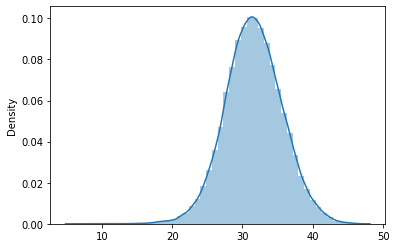

In [ ]:
preprocessor = GGNNPreprocessor()
"""
data = get_molnet_dataset('qm9', 
                          labels = 'cv',
                          preprocessor = preprocessor,
                          return_smiles = True, 
                          frac_train = 1.0,
                          frac_valid = 0.0,
                          frac_test = 0.0
                         )
"""
with open('./../data/trainingsets/Data.pickle', 'rb') as f:
    data = pickle.load (f)

X_smiles = []
SMILES = []
X_atoms = []
X_bonds = []
y = []

atom_lengths = []
atom_max = []
bonds_lengths = []

for smiles in data['smiles'][0]:
    SMILES.append(smiles)
    smiles += '.'
    X_smiles.append(smiles)
    
for d in data['dataset'][0]:
    X_atoms.append(d[0])
    X_bonds.append(d[1])
    
    atom_lengths.append(len(d[0]))
    atom_max.append(np.max(d[0]))
    bonds_lengths.append(d[1].shape[1])
    
    y.append(d[2])

with open('database_SMILES.pickle', 'wb') as f:
    pickle.dump((X_smiles, X_atoms, X_bonds, y), f)

MAX_NB_WORDS = 23
MAX_SEQUENCE_LENGTH = 35

tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      char_level = True,
                      filters = '', 
                      lower = False)
tokenizer.fit_on_texts(X_smiles)

X_smiles = tokenizer.texts_to_sequences(X_smiles)
X_smiles = pad_sequences(X_smiles, 
                         maxlen = MAX_SEQUENCE_LENGTH,
                         padding = 'post')

X_smiles = to_categorical(X_smiles)

atom_max = np.max(atom_max) 
bonds_max = np.max(bonds_lengths) 

X_atoms_ = []
for atom in X_atoms:
    if len(atom) < atom_max:
        pad_len = atom_max - len(atom)
        atom = np.pad(atom, (0, pad_len))
        
    X_atoms_.append(atom)
    
X_atoms = np.asarray(X_atoms_)

X_atoms = to_categorical(X_atoms)

X_bonds_ = []
for bond in X_bonds:
    if bond.shape[1] < bonds_max:
        pad_len = bonds_max - bond.shape[1]
        bond = np.pad(bond, ((0,0),(0,pad_len),(0,pad_len)))
        
    X_bonds_.append(bond)
    
X_bonds = np.asarray(X_bonds_)

SHAPE = list(X_smiles.shape) + [1]
X_smiles = X_smiles.reshape(SHAPE)

y = np.asarray(y).reshape([-1])

SHAPE = list(X_atoms.shape) + [1]
X_atoms = X_atoms.reshape(SHAPE)

X_bonds = X_bonds.transpose([0,2,3,1])

####
# ANALYSIS
sns.distplot(y);
####

SMILES = np.asarray(SMILES)
# TRAIN/VAL split
idx = np.random.choice(len(y), int(len(y) * 0.2), replace = False)
train_idx = np.setdiff1d(np.arange(len(y)), idx)

X_smiles_test, SMILES_test, X_atoms_test, X_bonds_test, y_test = X_smiles[idx], SMILES[idx],X_atoms[idx], X_bonds[idx], y[idx]
X_smiles_train, SMILES_train, X_atoms_train, X_bonds_train, y_train = X_smiles[train_idx], SMILES[train_idx],X_atoms[train_idx], X_bonds[train_idx], y[train_idx]

####
# ANALYSIS
X_atoms_train_ = X_atoms_train.reshape([X_atoms_train.shape[0], 
                                        9 * 10])
X_bonds_train_ = X_bonds_train.reshape([X_bonds_train.shape[0], 
                                        9 * 9 * 4])

X_atoms_test_ = X_atoms_test.reshape([X_atoms_test.shape[0],
                                      9 * 10])
X_bonds_test_ = X_bonds_test.reshape([X_bonds_test.shape[0],
                                      9 * 9 * 4])

In [ ]:
qm9_data = {}
qm9_data = pd.DataFrame(qm9_data)
qm9_data ['SMILES'] = SMILES
qm9_data ['X_smiles'] = list(X_smiles)
qm9_data ['cv'] = y

# create a uniform distributed Cv from dataset
bounds = list(range(21,43))
bounds[0] = 20.939
bounds[-1] = 42.237
print (bounds)
qm9_upsampled = {}
qm9_upsampled = pd.DataFrame(qm9_upsampled)
qm9_upsampled ['SMILES'] = []
qm9_upsampled ['X_smiles'] = []
qm9_upsampled ['cv'] = []
shapes = []
repeats = [7, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 5]
repeats_float = []
upsampled_shapes = []
real_shapes = []
for i, bound in enumerate(bounds[:-1]):
   x_ = qm9_data.loc[qm9_data['cv'] >= bound]
   x_ = x_.loc[x_['cv'] < bounds[i+1]]
   shapes.append(x_.shape[0])
   real_shapes.append(x_.shape[0])
   repeat = repeats[i]
   if repeat == 0:
       x = pd.DataFrame(np.repeat(x_.values, 1, axis=0), columns=x_.columns)
   else:
       x = pd.DataFrame(np.repeat(x_.values, repeat, axis=0), columns=x_.columns)
   count = 0
   if (x.shape[0] < 4000):
       while (x.shape[0] < 4000):
         x = x.append(x.iloc[count])
         count += 1
   upsampled_shapes.append (x.shape[0])
   if i == 0:
       x = x.iloc[0:4340]
   elif i == len(bounds)-2:
       x = x.iloc[0:4800]
   else:
       x = x.iloc[0:4000]
   qm9_upsampled = qm9_upsampled.append(x)
qm9_upsampled = qm9_upsampled.reset_index(drop = True)

qm9_upsampled = qm9_upsampled.sample(frac = 1)
qm9_upsampled = qm9_upsampled.reset_index(drop = True)

[20.939, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42.237]


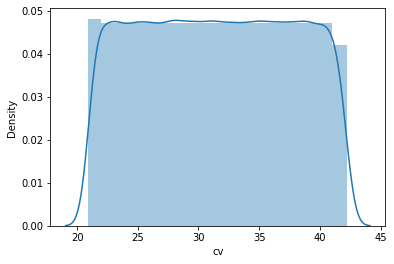

In [ ]:
#sns.distplot(qm9_upsampled['cv'], bins=bounds)

In [ ]:
print (qm9_upsampled['cv'].shape)
print (y.shape)
print (y_test.shape)
print (y_train.shape)

(84735,)
(133885,)
(26777,)
(107108,)


In [ ]:
# subsampling
idx = np.random.choice(len(y_train), int(len(y_train) * 0.6), replace = False)

X_smiles_train, SMILES_train, X_atoms_train, X_bonds_train, y_train = (X_smiles_train[idx], SMILES_train[idx],
                                                X_atoms_train[idx],
                                                X_bonds_train[idx],
                                                y_train[idx])


idx = np.random.choice(len(y_test), int(len(y_test) * 0.35), replace = False)

X_smiles_test, SMILES_test, X_atoms_test, X_bonds_test, y_test = (X_smiles_test[idx], SMILES_test[idx],
                                                     X_atoms_test[idx],
                                                     X_bonds_test[idx],
                                                     y_test[idx])
print (len(y_train))
print (len(y_test))
with open('./../data/trainingsets/60000_train_regular_qm9/image_train.pickle', 'wb') as f:
    pickle.dump((X_smiles_train, SMILES_train, X_atoms_train, X_bonds_train, y_train), f)
    
with open('./../data/trainingsets/60000_train_regular_qm9/image_test.pickle', 'wb') as f:
    pickle.dump((X_smiles_test, SMILES_test, X_atoms_test, X_bonds_test, y_test), f)

with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer.index_word, f)
"""
with open('database.pickle', 'wb') as f:
    pickle.dump((X_smiles, X_atoms, X_bonds, y), f)
"""

In [ ]:
X_smiles_gantrain = np.array (qm9_upsampled['X_smiles'])
SMILES_gantrain = np.array (qm9_upsampled['SMILES'])
cv_gantrain = np.array (qm9_upsampled['cv'])

In [ ]:
with open('./../data/trainingsets/60000_train_regular_qm9/train_GAN.pickle', 'wb') as f:
    pickle.dump((X_smiles_gantrain, SMILES_gantrain, cv_gantrain), f)

In [ ]:
pca_1 = PCA()
X_atoms_train_ = pca_1.fit_transform(X_atoms_train_)
X_atoms_test_ = pca_1.transform(X_atoms_test_)

pca_2 = PCA()
X_bonds_train_ = pca_2.fit_transform(X_bonds_train_)
X_bonds_test_ = pca_2.transform(X_bonds_test_)

# Atoms Distribution
plt.scatter(X_atoms_train_[:,0], X_atoms_train_[:,1], alpha = 0.3, c = 'blue');
plt.scatter(X_atoms_test_[:,0], X_atoms_test_[:,1], alpha = 0.3, c = 'red');
####
plt.close()
# Bonds Distribution
plt.scatter(X_bonds_train_[:,0], X_bonds_train_[:,1], alpha = 0.3, c = 'blue');
plt.scatter(X_bonds_test_[:,0], X_bonds_test_[:,1], alpha = 0.3, c = 'red');
"""
idx = np.where(y_train > 40)[0]
X_smiles_train, X_atoms_train, X_bonds_train, y_train = (X_smiles_train[idx],
                                                X_atoms_train[idx],
                                                X_bonds_train[idx],
                                                y_train[idx])


idx = np.where(y_test > 40)[0]
X_smiles_test, X_atoms_test, X_bonds_test, y_test = (X_smiles_test[idx],
                                                     X_atoms_test[idx],
                                                     X_bonds_test[idx],
                                                     y_test[idx])

"""